In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
sns.set(style="whitegrid")

In [4]:
filepath ="/cluster/home/taheeraa/code/master-thesis/01-multi-label/evaluation/logs/calculating-iou-rgb.out"

# iou

In [5]:
import re
from collections import OrderedDict

# Define the path to your log file
log_file_path = filepath

model_pattern = re.compile(r'\[INFO\].*-\s([A-Z0-9_]+)$')
iou_pattern = re.compile(r'avg_iou=(\d+\.\d+), img_index=(\d{8}_\d{3}\.png)')

model_iou_data = {
    'DENSENET121': set(),
    'SWIN_IN22K': set(),
    'VIT_IN1K': set(),
    'SWIN_SIMIM': set()
}

current_model = None

with open(log_file_path, 'r') as file:
    for line in file:
        model_match = model_pattern.search(line)
        if model_match:
            model_name = model_match.group(1)
            if model_name in model_iou_data:
                current_model = model_name

        if current_model:
            iou_match = iou_pattern.search(line)
            if iou_match:
                avg_iou = float(iou_match.group(1))
                img_index = iou_match.group(2)
                model_iou_data[current_model].add((avg_iou, img_index))

In [6]:
for model, data in model_iou_data.items():
    if not data:
        print(f"Model: {model} has no data available.")
        continue

    # Sorting data to handle ties by taking the first occurrence
    sorted_data = sorted(data, key=lambda x: (x[0], x[1]))

    # Highest, lowest, and average IoU calculations
    min_iou = sorted_data[0]
    max_iou = sorted_data[-1]
    avg_iou = sum(iou for iou, _ in data) / len(data)

    # Find the image with IoU closest to the average
    closest_avg_iou = min(data, key=lambda x: abs(x[0] - avg_iou))

    print(f"Model: {model}")
    print(f"Lowest IoU: {min_iou[0]}, Image ID: {min_iou[1]}")
    print(f"Highest IoU: {max_iou[0]}, Image ID: {max_iou[1]}")
    print(f"Average IoU: {avg_iou:.3f}, Closest Image ID: {closest_avg_iou[1]}")

Model: DENSENET121
Lowest IoU: 0.0, Image ID: 00000643_002.png
Highest IoU: 0.613, Image ID: 00011366_002.png
Average IoU: 0.059, Closest Image ID: 00028383_002.png
Model: SWIN_IN22K
Lowest IoU: 0.0, Image ID: 00000506_013.png
Highest IoU: 0.801, Image ID: 00013310_057.png
Average IoU: 0.108, Closest Image ID: 00016972_019.png
Model: VIT_IN1K
Lowest IoU: 0.0, Image ID: 00000583_008.png
Highest IoU: 0.729, Image ID: 00013625_069.png
Average IoU: 0.105, Closest Image ID: 00020405_041.png
Model: SWIN_SIMIM
Lowest IoU: 0.0, Image ID: 00000506_013.png
Highest IoU: 0.793, Image ID: 00022470_006.png
Average IoU: 0.163, Closest Image ID: 00030279_000.png


In [7]:
# Mapping for model titles
model_titles = {
    'DENSENET121': 'DenseNet121',
    'VIT_IN1K': 'ViT-IN1K',
    'SWIN_IN22K': 'Swin-IN22K',
    'SWIN_SIMIM': 'Swin-SimMIM'
}

bins = 30
# Iterate through each model and plot the IoU distribution
for (model_key, data), color in zip(model_iou_data.items(), colors_list):
    model_name = model_titles[model_key]  # Retrieve the model name from the mapping
    ious = [iou for iou, _ in data]  # Extract IoU values

    plt.figure(figsize=(10, 6))  # Set the figure size
    ax = sns.histplot(ious, bins=bins, kde=False, color=color, alpha=0.7, edgecolor='gray')
    ax.set(title=f'IoU distribution for {model_name}', xlabel='IoU', ylabel='Frequency')

    # More granular control over the x-axis ticks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))  # Set major ticks at every 0.05 interval
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))  # Set minor ticks at every 0.01 interval

    ax.tick_params(axis='x', which='major', labelsize=10)  # Major tick labels
    ax.tick_params(axis='x', which='minor', labelsize=8)  # Minor tick labels, smaller

    plt.tight_layout()
    plt.show(f"iou_distribution_{model_name.lower()}.png")
    plt.close()

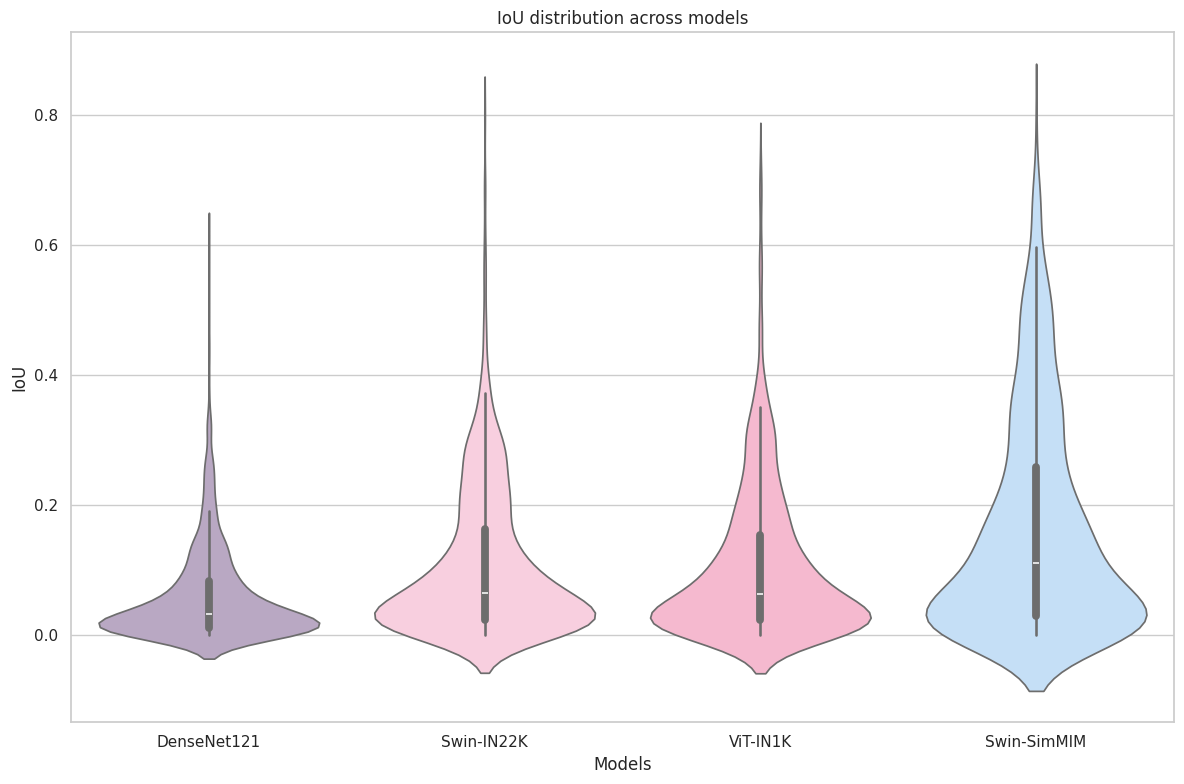

In [69]:
# Convert model keys to titles and iou to a DataFrame
data = []
for model_key, values in model_iou_data.items():
    for iou, _ in values:
        data.append((model_titles[model_key], iou))  # Use model_titles for correct naming

# Create DataFrame
df = pd.DataFrame(data, columns=['Model', 'IoU'])

# Plotting
plt.figure(figsize=(12, 8))
sns.violinplot(x='Model', y='IoU', data=df, palette=colors_list, hue='Model', legend=False)

plt.title('IoU distribution across models')
plt.xlabel('Models')
plt.ylabel('IoU')
plt.tight_layout()

# Save or show the plot
for spine in ax.spines.values():
    spine.set_edgecolor('lightgrey')
plt.savefig('iou_violin_distribution.png')

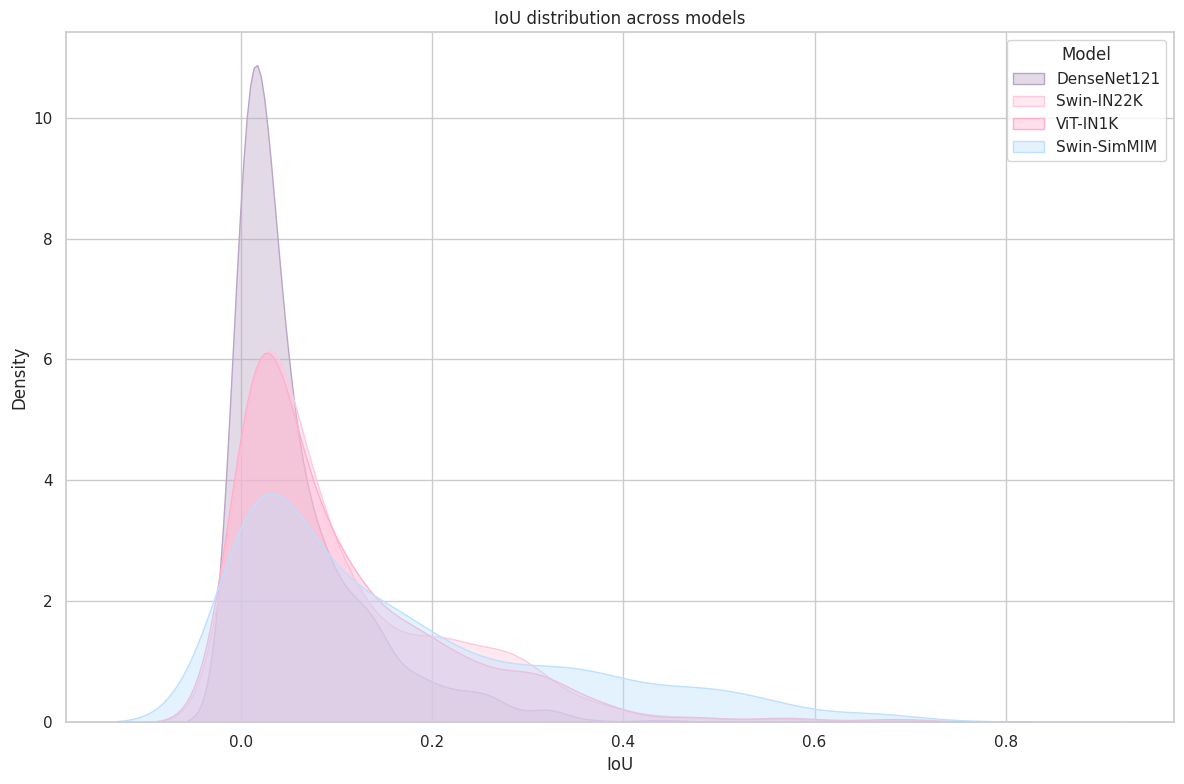

In [9]:
# Create a single figure for overlapping KDE plots
plt.figure(figsize=(12, 8))

# Plot KDEs for each model
for (model_key, data), color in zip(model_iou_data.items(), colors_list):
    ious = [iou for iou, _ in data]
    sns.kdeplot(ious, color=color, label=model_titles[model_key], fill=True, common_norm=False, alpha=0.4)

plt.title('IoU distribution across models')
plt.xlabel('IoU')
plt.ylabel('Density')
plt.legend(title='Model')  # Add a legend with a title
plt.tight_layout()
plt.show('combined_histograms_iou_distribution.png')


# class-wise auc

In [10]:
# Define the disease classes
diseases = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural Thickening", "Hernia"
]

# AUC scores with TTA for each model
auc_scores_with_tta = {
    'DenseNet121': [0.770, 0.875, 0.828, 0.698, 0.809, 0.751, 0.727, 0.856, 0.746, 0.836, 0.881, 0.816, 0.761, 0.854],
    'ViT-IN1K': [0.756, 0.866, 0.818, 0.697, 0.785, 0.736, 0.713, 0.844, 0.731, 0.842, 0.855, 0.797, 0.751, 0.888],
    'Swin-IN22K': [0.741, 0.781, 0.795, 0.695, 0.713, 0.698, 0.676, 0.818, 0.707, 0.824, 0.803, 0.765, 0.724, 0.803],
    'Swin-SimMIM': [0.791, 0.905, 0.847, 0.720, 0.846, 0.767, 0.744, 0.878, 0.771, 0.861, 0.931, 0.852, 0.806, 0.916]
}

# Create a DataFrame from the dictionary
df_auc = pd.DataFrame(auc_scores_with_tta, index=diseases)

# Transpose the DataFrame to have diseases as columns and models as rows, if needed
df_auc = df_auc.T  # Uncomment if you prefer models as rows and diseases as columns

# Show the DataFrame
df_auc

,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural Thickening,Hernia
DenseNet121,0.770,0.875,0.828,0.698,0.809,0.751,0.727,0.856,0.746,0.836,0.881,0.816,0.761,0.854
ViT-IN1K,0.756,0.866,0.818,0.697,0.785,0.736,0.713,0.844,0.731,0.842,0.855,0.797,0.751,0.888
Swin-IN22K,0.741,0.781,0.795,0.695,0.713,0.698,0.676,0.818,0.707,0.824,0.803,0.765,0.724,0.803
Swin-SimMIM,0.791,0.905,0.847,0.720,0.846,0.767,0.744,0.878,0.771,0.861,0.931,0.852,0.806,0.916


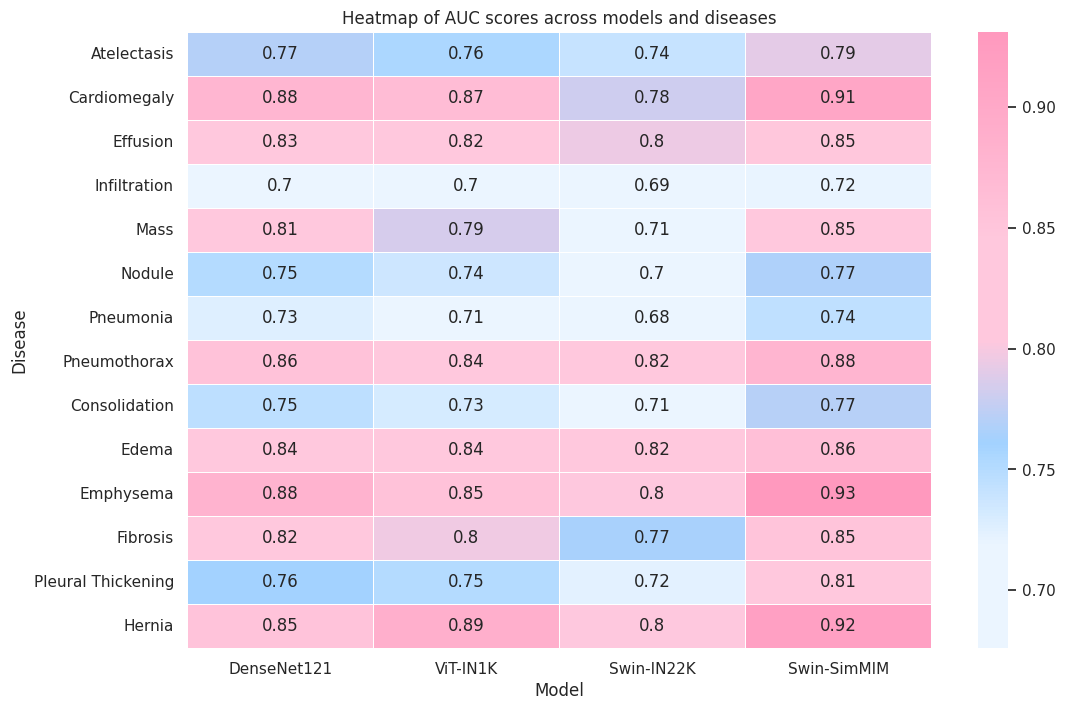

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assuming your custom_colors and df_auc are already defined
custom_colors = ["#FF99BE","#FFAFCC", "#FFC8DD","#FFC8DD", "#A2D2FF", "#EBF5FF",  "#EBF5FF"]
# Reverse the color order for visual appeal
custom_colors = custom_colors[::-1]

# Create a colormap from the list of colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors, N=200)

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 8))
sns.heatmap(df_auc.T, annot=True, cmap=cmap, linewidths=.5)
plt.title('Heatmap of AUC scores across models and diseases')
plt.xlabel('Model')
plt.ylabel('Disease')
plt.show("heatmap_auc_scores.png")

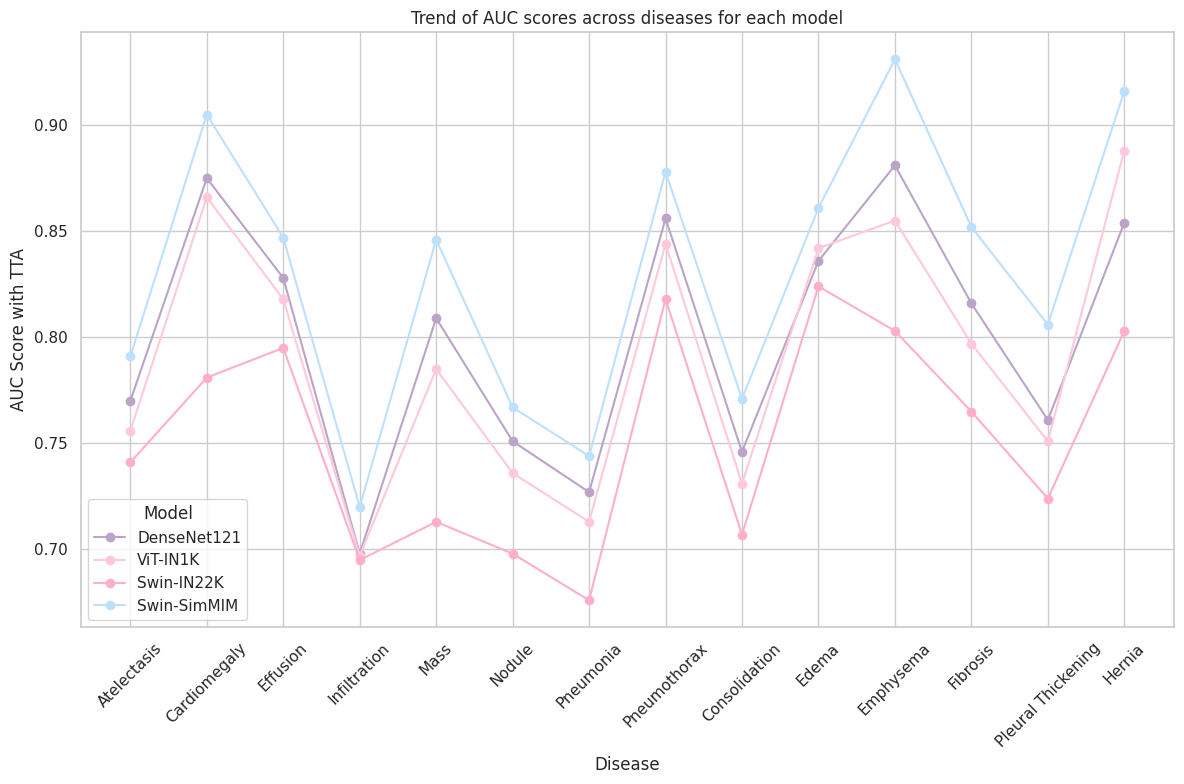

In [66]:
# Create a single figure for overlapping KDE plots
plt.figure(figsize=(12, 8))
df_auc_transposed=df_auc.T

for model, color in zip(df_auc_transposed.columns, colors_list):
    plt.plot(df_auc_transposed[model], marker='o', label=model, color=color)
plt.title('Trend of AUC scores across diseases for each model')
plt.xlabel('Disease')
plt.ylabel('AUC Score with TTA')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_scores_trend.png")

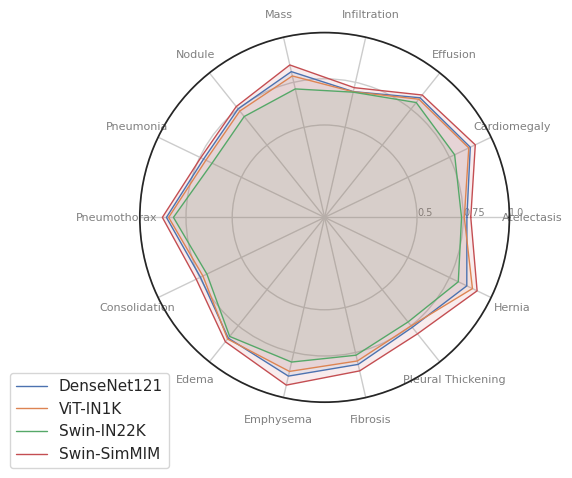

In [ ]:
from math import pi

# Sample DataFrame
# Ensure df_auc is loaded as before

# Number of variables we're plotting.
categories = list(df_auc.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # complete the loop

# Initialise the radar plot
ax = plt.subplot(111, polar=True)

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.5, 0.75, 1.0], ["0.5", "0.75", "1.0"], color="grey", size=7)
plt.ylim(0,1)

# Plot each individual model
for idx, row in df_auc.iterrows():
    values = df_auc.loc[idx].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=idx)
    ax.fill(angles, values, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

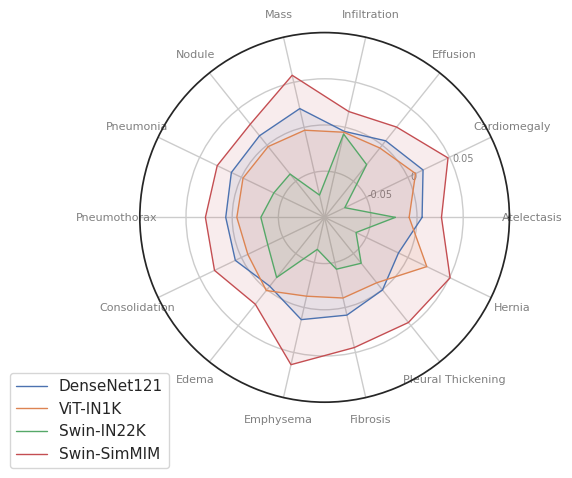

In [ ]:
mean_auc = df_auc.mean(axis=0)

# Calculate the difference from the mean for each model
df_difference_from_mean = df_auc.subtract(mean_auc, axis=1)

# Radar chart setup
categories = list(df_auc.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
plt.yticks([-0.05, 0, 0.05], ["-0.05", "0", "0.05"], color="grey", size=7)
plt.ylim(-0.1, 0.1)

for idx, row in df_difference_from_mean.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=idx)
    ax.fill(angles, values, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

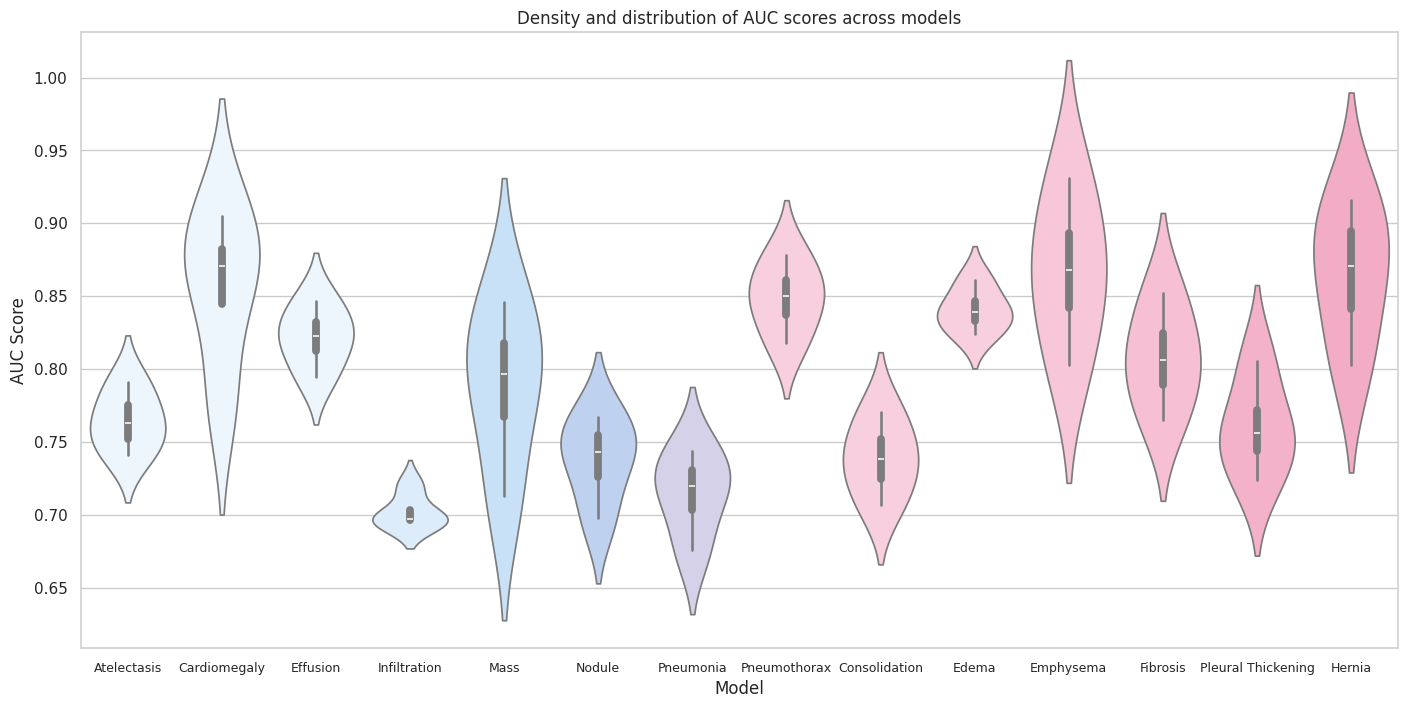

In [67]:
# Assuming df_auc is already defined and correctly formatted with each column as a model
cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors, N=20)

# To apply a cmap, we might manually map each category to a color using the cmap
models = df_auc.columns.tolist()
color_palette = {model: cmap(i / len(models)) for i, model in enumerate(models)}

plt.figure(figsize=(17, 8))
ax = sns.violinplot(data=df_auc, palette=color_palette)
plt.title('Density and distribution of AUC scores across models')
plt.xlabel('Model')
plt.ylabel('AUC Score')
# Make the frame around the graph lighter
for spine in ax.spines.values():
    spine.set_edgecolor('lightgrey')

# Adjust only the x-axis tick label sizes
ax.tick_params(axis='x', labelsize=9)

plt.savefig("density_auc_scores_all_models.png")


# test time

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
diseases = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 
    'Emphysema', 'Fibrosis', 'Pleural Thickening', 'Hernia'
]

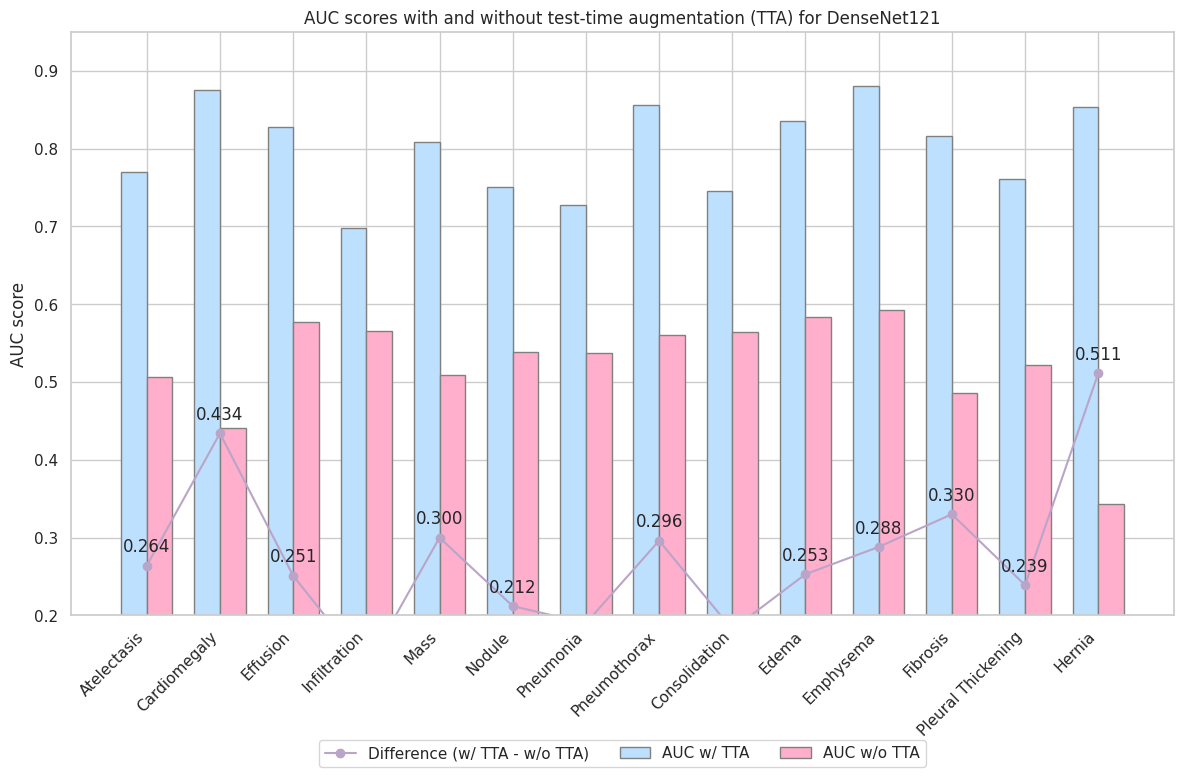

In [16]:
#densenet121
auc_w_tta = [
    0.770, 0.875, 0.828, 0.698, 0.809, 
    0.751, 0.727, 0.856, 0.746, 0.836, 
    0.881, 0.816, 0.761, 0.854
]

auc_wo_tta = [
    0.506, 0.441, 0.577, 0.565, 0.509, 
    0.539, 0.537, 0.560, 0.564, 0.583, 
    0.593, 0.486, 0.522, 0.343
]

# Calculate the difference
auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(diseases))
bar_width = 0.35

bars1 = ax.bar(index, auc_w_tta, bar_width, label='AUC w/ TTA', color=colors_list[3],edgecolor='gray')
bars2 = ax.bar(index + bar_width, auc_wo_tta, bar_width, label='AUC w/o TTA', color=colors_list[2],edgecolor='gray')
line, = ax.plot(index + bar_width / 2, auc_diff, 'o-', label='Difference (w/ TTA - w/o TTA)', color=colors_list[0])

ax.set_ylabel('AUC score')
ax.set_title('AUC scores with and without test-time augmentation (TTA) for DenseNet121')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(diseases, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)  # Move legend below the plot


# Add labels for the line plot
for i, txt in enumerate(auc_diff):
    ax.annotate(f'{txt:.3f}', (index[i] + bar_width / 2, auc_diff[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center')

plt.tight_layout()
plt.show("densenet121-auc-class-difference.png")


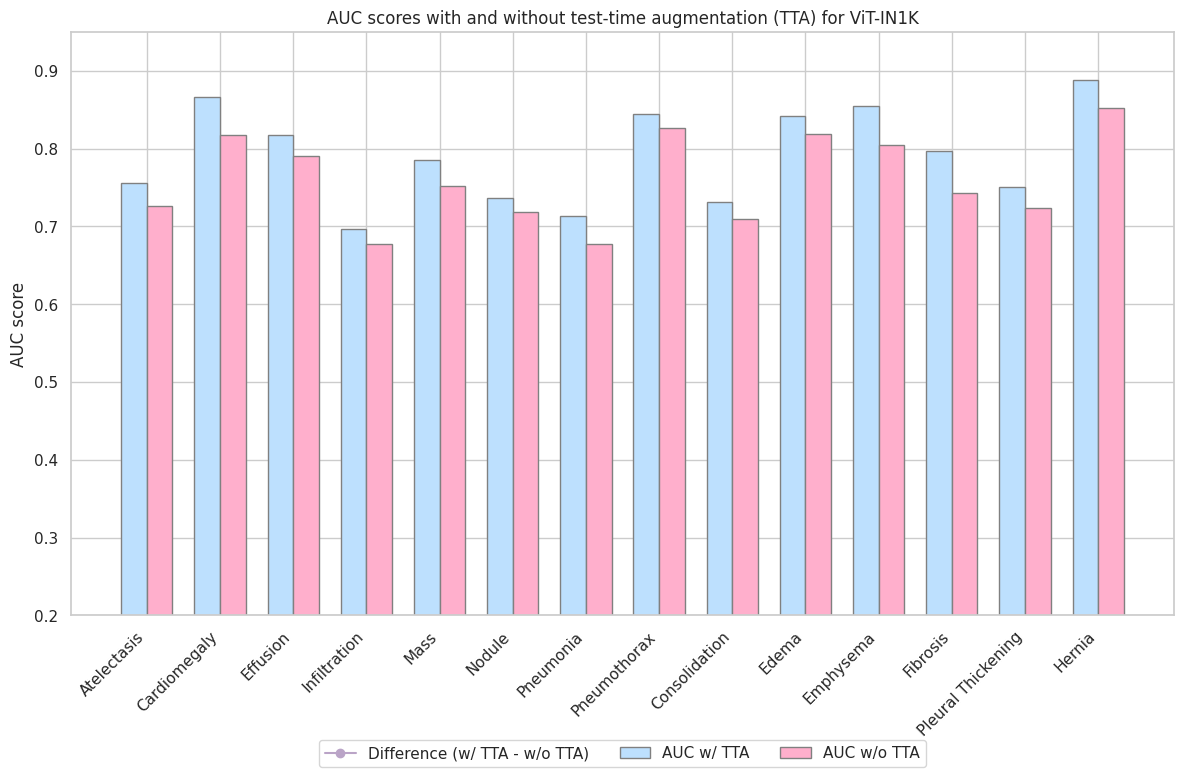

In [18]:
#vit-in1k
auc_wo_tta = [
    0.756, 0.866, 0.818, 0.697, 0.785, 
    0.736, 0.713, 0.844, 0.731, 0.842, 
    0.855, 0.797, 0.751, 0.888
]

auc_wo_tta = [
    0.726, 0.818, 0.790, 0.677, 0.752, 
    0.719, 0.677, 0.826, 0.709, 0.819, 
    0.804, 0.743, 0.723, 0.852
]

# Calculate the difference
auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(diseases))
bar_width = 0.35

bars1 = ax.bar(index, auc_w_tta, bar_width, label='AUC w/ TTA', color=colors_list[3],edgecolor='gray')
bars2 = ax.bar(index + bar_width, auc_wo_tta, bar_width, label='AUC w/o TTA', color=colors_list[2],edgecolor='gray')
line, = ax.plot(index + bar_width / 2, auc_diff, 'o-', label='Difference (w/ TTA - w/o TTA)', color=colors_list[0])

ax.set_ylabel('AUC score')
ax.set_title('AUC scores with and without test-time augmentation (TTA) for ViT-IN1K')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(diseases, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)  # Move legend below the plot


# Add labels for the line plot
for i, txt in enumerate(auc_diff):
    ax.annotate(f'{txt:.3f}', (index[i] + bar_width / 2, auc_diff[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center')

plt.tight_layout()
plt.show("vitin1k-auc-class-difference.png")


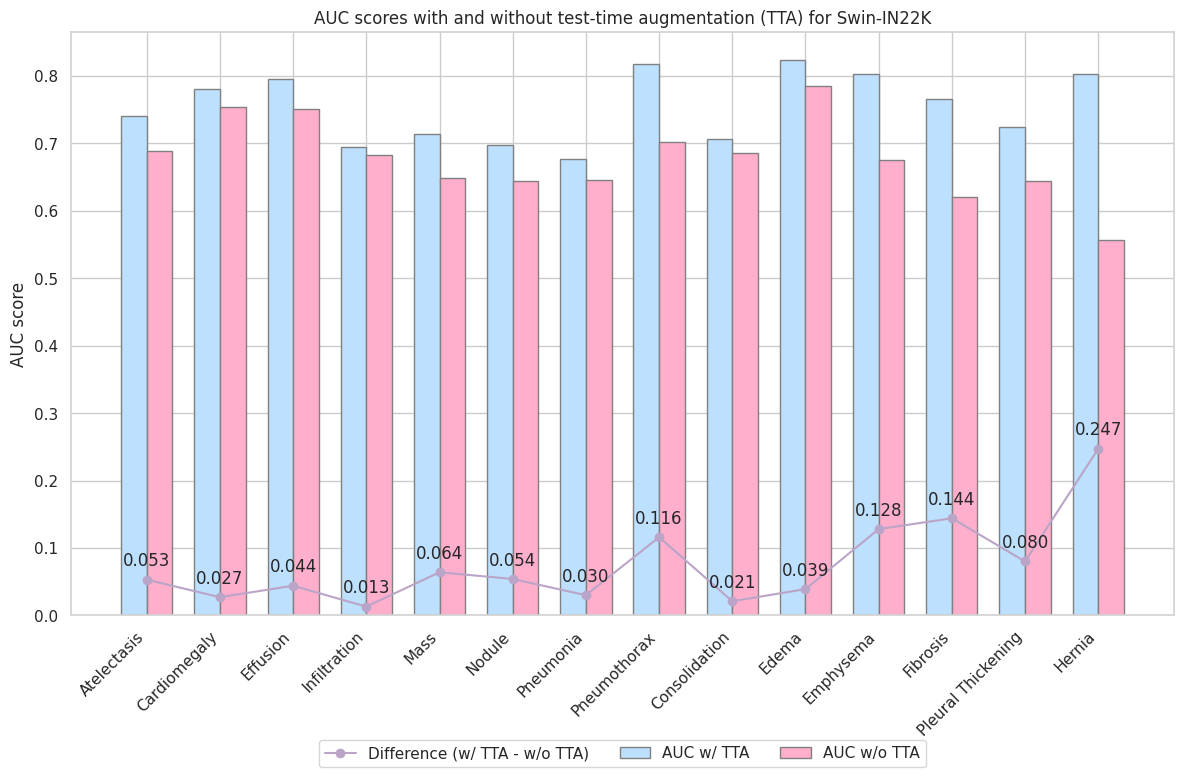

In [63]:
auc_w_tta = [
    0.741, 0.781, 0.795, 0.695, 0.713, 
    0.698, 0.676, 0.818, 0.707, 0.824, 
    0.803, 0.765, 0.724, 0.803
]

auc_wo_tta = [
    0.688, 0.754, 0.751, 0.682, 0.649, 
    0.644, 0.646, 0.702, 0.686, 0.785, 
    0.675, 0.621, 0.644, 0.556
]

# Calculate the difference
auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(diseases))
bar_width = 0.35

bars1 = ax.bar(index, auc_w_tta, bar_width, label='AUC w/ TTA', color=colors_list[3],edgecolor='gray')
bars2 = ax.bar(index + bar_width, auc_wo_tta, bar_width, label='AUC w/o TTA', color=colors_list[2],edgecolor='gray')
line, = ax.plot(index + bar_width / 2, auc_diff, 'o-', label='Difference (w/ TTA - w/o TTA)', color=colors_list[0])

ax.set_ylabel('AUC score')
ax.set_title('AUC scores with and without test-time augmentation (TTA) for Swin-IN22K')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(diseases, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)  # Move legend below the plot


# Add labels for the line plot
for i, txt in enumerate(auc_diff):
    ax.annotate(f'{txt:.3f}', (index[i] + bar_width / 2, auc_diff[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center')
for spine in ax.spines.values():
    spine.set_edgecolor('lightgrey')
plt.tight_layout()
plt.show("swinin22k-auc-class-difference.png")

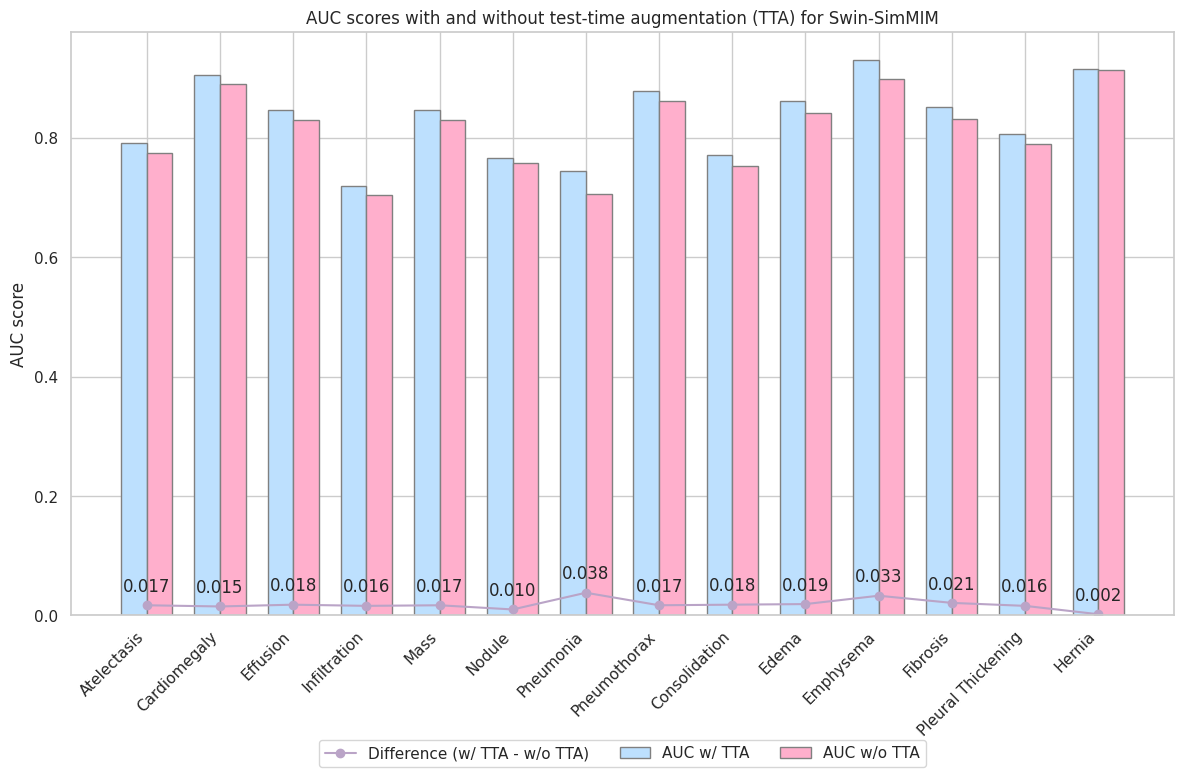

In [20]:
auc_w_tta = [
    0.791, 0.905, 0.847, 0.720, 0.846, 
    0.767, 0.744, 0.878, 0.771, 0.861, 
    0.931, 0.852, 0.806, 0.916
]

auc_wo_tta = [
    0.774, 0.890, 0.829, 0.704, 0.829, 
    0.757, 0.706, 0.861, 0.753, 0.842, 
    0.898, 0.831, 0.790, 0.914
]

# Calculate the difference
auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(diseases))
bar_width = 0.35

bars1 = ax.bar(index, auc_w_tta, bar_width, label='AUC w/ TTA', color=colors_list[3], edgecolor='gray')
bars2 = ax.bar(index + bar_width, auc_wo_tta, bar_width, label='AUC w/o TTA', color=colors_list[2], edgecolor='gray')
line, = ax.plot(index + bar_width / 2, auc_diff, 'o-', label='Difference (w/ TTA - w/o TTA)', color=colors_list[0])

ax.set_ylabel('AUC score')
ax.set_title('AUC scores with and without test-time augmentation (TTA) for Swin-SimMIM')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(diseases, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)  # Move legend below the plot


# Add labels for the line plot
for i, txt in enumerate(auc_diff):
    ax.annotate(f'{txt:.3f}', (index[i] + bar_width / 2, auc_diff[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center')

plt.tight_layout()
plt.savefig("swinsimmim-auc-class-difference.png")

# test-time overall

In [79]:
import numpy as np

# Function to calculate mean AUC
def calculate_mean_auc(auc_list):
    return np.mean(auc_list)

# Organized data using a dictionary
models_auc_scores = {
    'densenet121': {
        'name': 'DenseNet121',
        'auc_w_tta': [
            0.770, 0.875, 0.828, 0.698, 0.809, 
            0.751, 0.727, 0.856, 0.746, 0.836, 
            0.881, 0.816, 0.761, 0.854
        ],
        'auc_wo_tta': [
            0.506, 0.441, 0.577, 0.565, 0.509, 
            0.539, 0.537, 0.560, 0.564, 0.583, 
            0.593, 0.486, 0.522, 0.343
        ]
    },
    'vit-in1k': {
        'name': 'ViT-IN1K',
        'auc_w_tta': [
            0.756, 0.866, 0.818, 0.697, 0.785, 
            0.736, 0.713, 0.844, 0.731, 0.842, 
            0.855, 0.797, 0.751, 0.888
        ],
        'auc_wo_tta': [
            0.726, 0.818, 0.790, 0.677, 0.752, 
            0.719, 0.677, 0.826, 0.709, 0.819, 
            0.804, 0.743, 0.723, 0.852
        ]
    },
    'swin-in22k': {
        'name': 'Swin-IN22K',
        'auc_w_tta': [
            0.741, 0.781, 0.795, 0.695, 0.713, 
            0.698, 0.676, 0.818, 0.707, 0.824, 
            0.803, 0.765, 0.724, 0.803
        ],
        'auc_wo_tta': [
            0.688, 0.754, 0.751, 0.682, 0.649, 
            0.644, 0.646, 0.702, 0.686, 0.785, 
            0.675, 0.621, 0.644, 0.556
        ]
    },
    'swin-simmim': {
        'name': 'Swin-SimMIM',
        'auc_w_tta': [
            0.791, 0.905, 0.847, 0.720, 0.846, 
            0.767, 0.744, 0.878, 0.771, 0.861, 
            0.931, 0.852, 0.806, 0.916
        ],
        'auc_wo_tta': [
            0.774, 0.890, 0.829, 0.704, 0.829, 
            0.757, 0.706, 0.861, 0.753, 0.842, 
            0.898, 0.831, 0.790, 0.914
        ]
    }
}

# Calculate and add mean AUC scores to the dictionary
for model, scores in models_auc_scores.items():
    scores['mean_auc_w_tta'] = calculate_mean_auc(scores['auc_w_tta'])
    scores['mean_auc_wo_tta'] = calculate_mean_auc(scores['auc_wo_tta'])

models_auc_scores.keys(), models_auc_scores['densenet121'].keys()

(dict_keys(['densenet121', 'vit-in1k', 'swin-in22k', 'swin-simmim']),
 dict_keys(['name', 'auc_w_tta', 'auc_wo_tta', 'mean_auc_w_tta', 'mean_auc_wo_tta']))

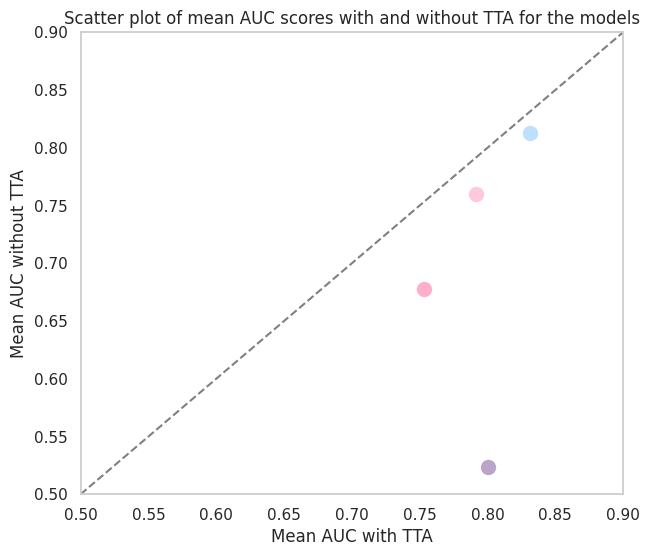

In [114]:
model_names = [models_auc_scores[model]['name'] for model in models_auc_scores]
mean_auc_w_tta = [models_auc_scores[model]['mean_auc_w_tta'] for model in models_auc_scores]
mean_auc_wo_tta = [models_auc_scores[model]['mean_auc_wo_tta'] for model in models_auc_scores]

# Scatter plot
plt.figure(figsize=(7, 6))

for model, color in zip(models_auc_scores, colors_list):
    name = models_auc_scores[model]['name']
    plt.scatter(models_auc_scores[model]['mean_auc_w_tta'], models_auc_scores[model]['mean_auc_wo_tta'], label=name,s=100, color=color)

plt.plot([0.5, 1.0], [0.5, 1.0], color='gray', linestyle='--')  # y=x line
plt.xlim(0.5, 0.9)
plt.ylim(0.5, 0.9)
# Adding labels and title
plt.xlabel('Mean AUC with TTA')
plt.ylabel('Mean AUC without TTA')
plt.title('Scatter plot of mean AUC scores with and without TTA for the models')

# Adding legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)  # Move legend below the plot

# remove grid
plt.grid(False)
plt.tight_layout()
# Display plot
plt.savefig("mauc_tta_scatter_plot.png")

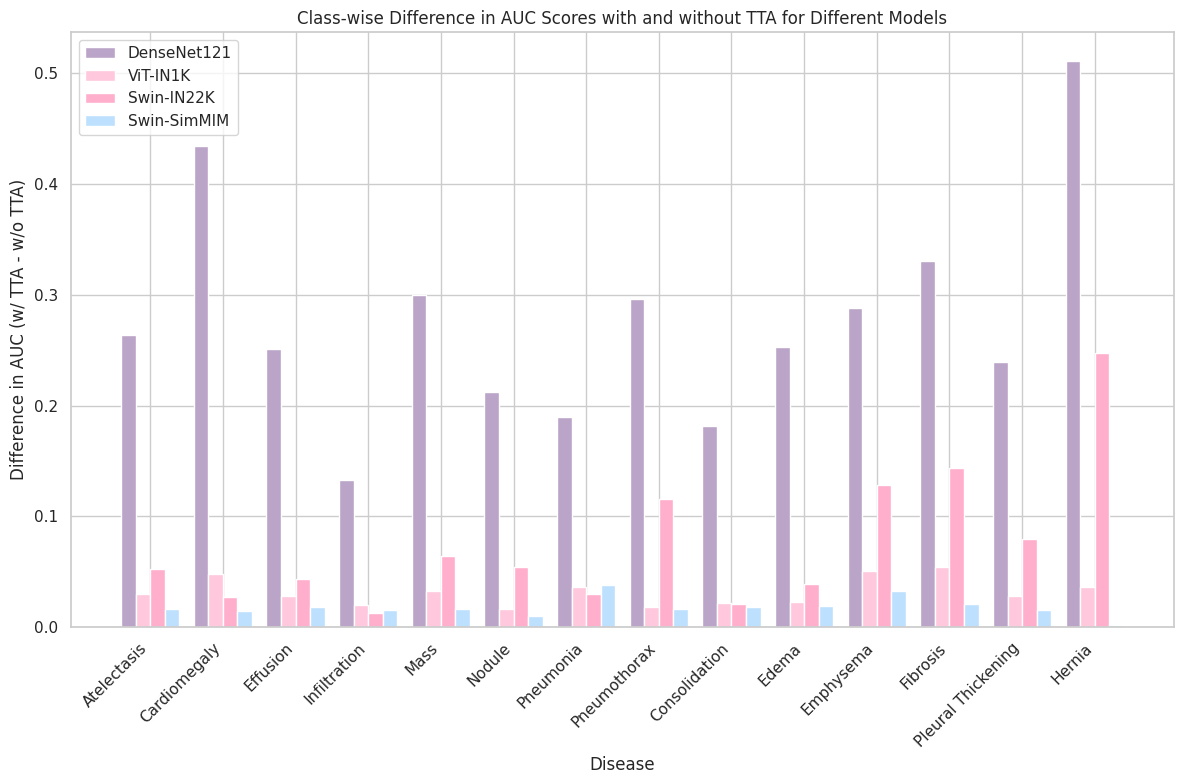

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting
for i, model in enumerate(models_auc_scores):
    name = models_auc_scores[model]['name']
    auc_w_tta = models_auc_scores[model]['auc_w_tta']
    auc_wo_tta = models_auc_scores[model]['auc_wo_tta']
    auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)
    
    # Plot bars for w/ TTA and w/o TTA
    index = np.arange(len(diseases))
    bar_width = 0.2
    plt.bar(index + i * bar_width, auc_diff, bar_width, label=name, color=colors[i % len(colors)])

# Add labels, title, and legend
plt.xlabel('Disease')
plt.ylabel('Difference in AUC (w/ TTA - w/o TTA)')
plt.title('Class-wise Difference in AUC Scores with and without TTA for Different Models')
plt.xticks(index + bar_width * 1.5, diseases, rotation=45, ha='right')
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

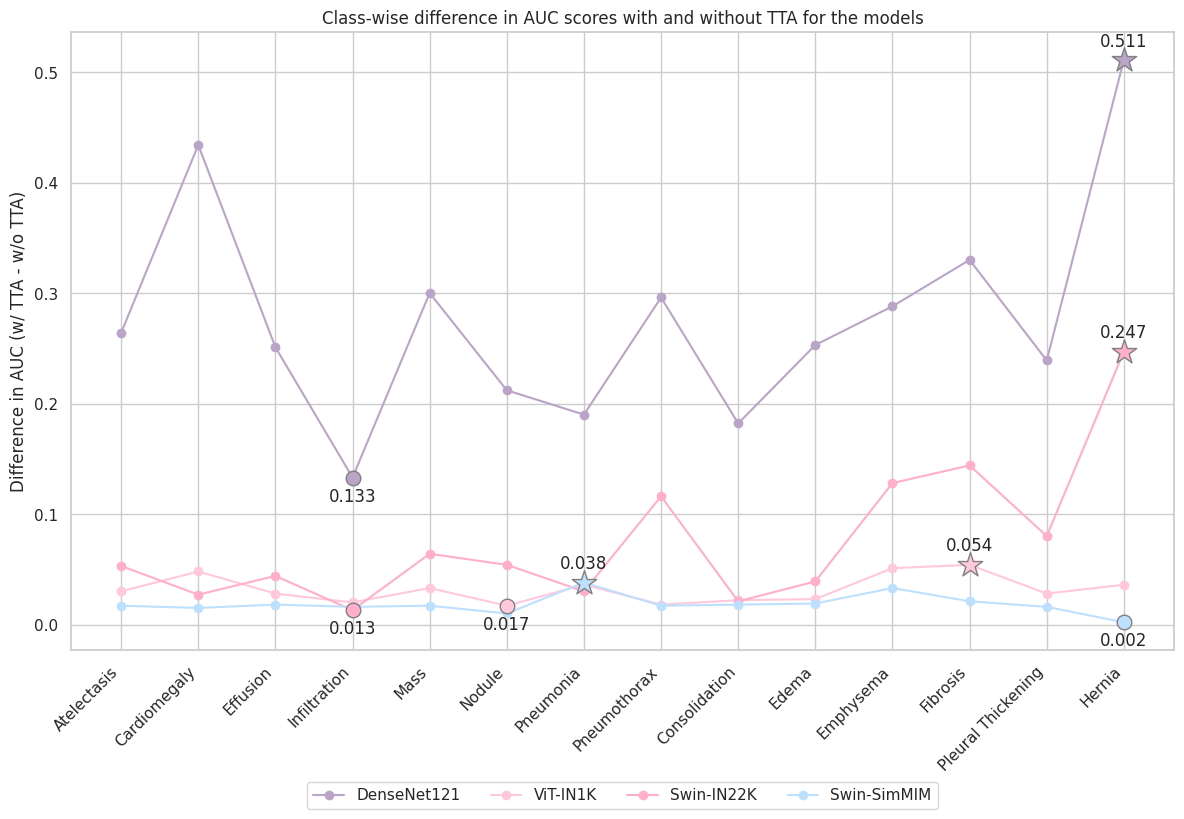

In [121]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))

for i, model in enumerate(models_auc_scores):
    name = models_auc_scores[model]['name']
    auc_w_tta = models_auc_scores[model]['auc_w_tta']
    auc_wo_tta = models_auc_scores[model]['auc_wo_tta']
    auc_diff = np.array(auc_w_tta) - np.array(auc_wo_tta)
    
    # Plot lines for difference in AUC without markers
    index = np.arange(len(diseases))
    plt.plot(index, auc_diff,  'o-', label=name, color=colors[i % len(colors)])
    
    # Highlight the lowest and highest differences with different markers and outlines
    min_diff_idx = np.argmin(auc_diff)
    max_diff_idx = np.argmax(auc_diff)
    plt.scatter([min_diff_idx], [auc_diff[min_diff_idx]], facecolors=colors[i % len(colors)], edgecolors='gray', marker='o', s=110, zorder=5)
    plt.scatter([max_diff_idx], [auc_diff[max_diff_idx]], facecolors=colors[i % len(colors)], edgecolors='gray', marker='*', s=340, zorder=5)
    
    # Annotate the lowest and highest differences
    plt.annotate(f'{auc_diff[min_diff_idx]:.3f}', (min_diff_idx, auc_diff[min_diff_idx]), textcoords="offset points", xytext=(0,-17), ha='center')
    plt.annotate(f'{auc_diff[max_diff_idx]:.3f}', (max_diff_idx, auc_diff[max_diff_idx]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels, title, and legend
#plt.xlabel('Disease')
plt.ylabel('Difference in AUC (w/ TTA - w/o TTA)')
plt.title('Class-wise difference in AUC scores with and without TTA for the models')
plt.xticks(index, diseases, rotation=45, ha='right')
plt.legend()

# Display plot
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=4)  # Move legend below the plot
plt.savefig("compare-tta-class-wise-auc.png")